In [7]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## 1. Encoding Function

In [ ]:
def modify_selected_channels(pixel_rgb, message_bits, bits_per_channel, channels_to_encode):
    """Modify selected color channels with message bits"""
    expected_length = len(channels_to_encode) * bits_per_channel
    message_bits = message_bits.ljust(expected_length, '0')
    
    modified_pixel = list(pixel_rgb)
    bit_idx = 0
    
    for channel in channels_to_encode:
        bits = message_bits[bit_idx:bit_idx + bits_per_channel]
        bit_idx += bits_per_channel
        channel_idx = 'RGB'.index(channel)
        value = modified_pixel[channel_idx]
        
        # Mask to clear the LSBs
        mask = 0xFF ^ ((1 << bits_per_channel) - 1)
        cleared = value & mask
        
        # Insert new bits
        modified_pixel[channel_idx] = cleared | int(bits, 2)
    
    return tuple(modified_pixel)


def get_pixel_position(pixel_index, gap, start_row, start_col, rows, cols, horizontal):
    """Get exact pixel position for given index - used by both encode and decode"""
    actual_pixel_offset = pixel_index * (gap + 1)
    
    if horizontal:
        total_offset = start_row * cols + start_col + actual_pixel_offset
        current_row = total_offset // cols
        current_col = total_offset % cols
    else:
        total_offset = start_col * rows + start_row + actual_pixel_offset
        current_col = total_offset // rows
        current_row = total_offset % rows
    
    return current_row, current_col


def encode_message(img_path, out_path, message, start_position=(0, 0), gap=0,
                   channels='RGB', num_bits=1, delimiter_start='#', delimiter_end='#',
                   horizontal=1):
    """
    Parameters:
    - img_path: Path to input image
    - out_path: Path for encoded output image
    - message: Text message to hide
    - start_position: (row, col) starting pixel
    - gap: Skip pixels between encoding (0=consecutive)
    - channels: Color channels to use ('R', 'G', 'B', 'RGB')
    - num_bits: Number of LSB bits to modify (1-8)
    - delimiter_start: Start delimiter (single/multi-char)
    - delimiter_end: End delimiter (single/multi-char)
    - horizontal: 1=row-wise, 0=column-wise traversal
    """
    valid_channels = set('RGB')
    input_channels = set(channels.upper())
    if not input_channels.issubset(valid_channels):
        print("Error: Invalid channel input. Use only 'R', 'G', 'B'.")
        return False

    if not (1 <= num_bits <= 8):
        print("Error: Invalid num_bits. num_bits must be between 1 and 8.")
        return False

    if horizontal not in [0, 1]:
        print("Error: Invalid horizontal value. It should be either 0 or 1.")
        return False

    img = np.array(Image.open(img_path))
    rows, cols, _ = img.shape
    channels = channels.upper()

    r_start, c_start = start_position
    if r_start >= rows or c_start >= cols:
        print(f"Error: Invalid start_position. The start position {start_position} exceeds image dimensions ({rows}, {cols}).")
        return False

    binary_message = ''.join(format(ord(c), '08b') for c in message)

    if delimiter_start:
        binary_start = ''.join(format(ord(c), '08b') for c in delimiter_start)
        binary_message = binary_start + binary_message

    if delimiter_end:
        binary_end = ''.join(format(ord(c), '08b') for c in delimiter_end)
        binary_message += binary_end

    bits_per_pixel = len(channels) * num_bits
    
    if horizontal:
        total_pixels = (cols - c_start) + (rows - r_start - 1) * cols
    else:
        total_pixels = (rows - r_start) + (cols - c_start - 1) * rows
    
    available_pixels = total_pixels // (gap + 1)
    available_bits = available_pixels * bits_per_pixel

    padded_message_length = len(binary_message)
    if len(binary_message) % bits_per_pixel != 0:
        padded_message_length = ((len(binary_message) // bits_per_pixel) + 1) * bits_per_pixel

    if padded_message_length > available_bits:
        print(f"Error: Message is too large. Max bits available: {available_bits}, Required: {padded_message_length} (including padding)")
        return False

    if len(binary_message) % bits_per_pixel != 0:
        binary_message = binary_message.ljust(padded_message_length, '0')

    bit_pointer = 0
    pixel_index = 0
    
    while bit_pointer < len(binary_message):
        current_row, current_col = get_pixel_position(pixel_index, gap, r_start, c_start, rows, cols, horizontal)
        
        if current_row >= rows or current_col >= cols:
            break
            
        pixel = img[current_row, current_col]
        message_bits = binary_message[bit_pointer: bit_pointer + bits_per_pixel]
        modified_pixel = modify_selected_channels(pixel, message_bits, num_bits, channels)
        img[current_row, current_col] = modified_pixel
        bit_pointer += bits_per_pixel
        pixel_index += 1

    # Save image
    Image.fromarray(img).save(out_path)
    return True

# Display original and encoded images

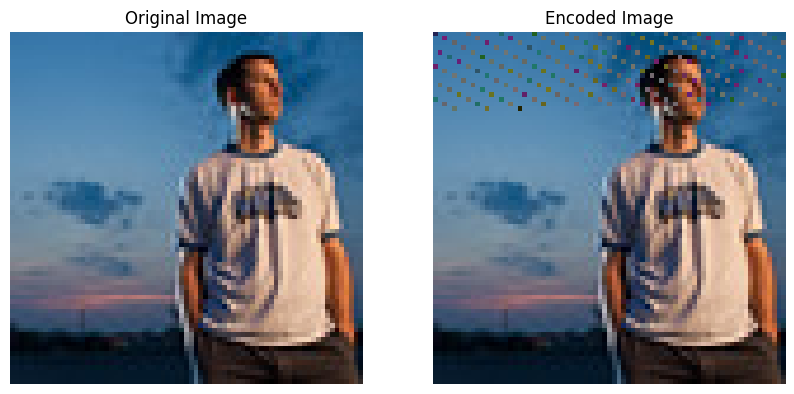

In [ ]:
def display_images(original_path, encoded_path):
    """Display original and encoded images side by side"""
    original_img = Image.open(original_path)
    encoded_img = Image.open(encoded_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Encoded Image")
    plt.imshow(encoded_img)
    plt.axis('off')

    plt.show()
    
message_to_hide = "This is a hidden message without using verification."*10
original_image = 'images/man.jpg'
encoded_image = 'images/simple_encoded.png'

encode_message(
    img_path=original_image,
    out_path=encoded_image,
    message=message_to_hide,
    start_position=(0, 0),
    gap=6,
    channels='RGB',
    num_bits=8,
    delimiter_start='##',
    delimiter_end='##',
    horizontal=1
)



display_images(original_image, encoded_image)


## 2. Decoding Functions


In [ ]:
def extract_lsb_bits(pixel_rgb, bits_per_channel, channels_to_decode):
    """Extract LSB bits from pixel channels"""
    extracted_bits = ''
    
    for channel in channels_to_decode:
        channel_idx = 'RGB'.index(channel)
        value = pixel_rgb[channel_idx]
        
        # Extract the LSBs using mask
        mask = (1 << bits_per_channel) - 1
        bits = value & mask
        extracted_bits += format(bits, f'0{bits_per_channel}b')
    
    return extracted_bits


def decode_message(img_path, start_position=(0, 0), gap=0,
                   channels='RGB', num_bits=1, delimiter_start='#', delimiter_end='#',
                   horizontal=1):
    """
    Parameters:
    - img_path: Path to encoded image
    - start_position: (row, col) starting pixel (must match encoding)
    - gap: Skip pixels between decoding (must match encoding)
    - channels: Color channels used (must match encoding)
    - num_bits: Number of LSB bits used (must match encoding)
    - delimiter_start: Start delimiter (single/multi-char, must match encoding)
    - delimiter_end: End delimiter (single/multi-char, must match encoding)
    - horizontal: Traversal direction (must match encoding)
    """
    valid_channels = set('RGB')
    input_channels = set(channels.upper())
    if not input_channels.issubset(valid_channels):
        print("Error: Invalid channel input. Use only 'R', 'G', 'B'.")
        return ""

    if not (1 <= num_bits <= 8):
        print("Error: Invalid num_bits. num_bits must be between 1 and 8.")
        return ""

    if horizontal not in [0, 1]:
        print("Error: Invalid horizontal value. It should be either 0 or 1.")
        return ""

    img = np.array(Image.open(img_path))
    rows, cols, _ = img.shape
    channels = channels.upper()
    
    r_start, c_start = start_position
    if r_start >= rows or c_start >= cols:
        print(f"Error: Invalid start_position. The start position {start_position} exceeds image dimensions ({rows}, {cols}).")
        return ""

    bits_per_pixel = len(channels) * num_bits
    extracted_bits = ''
    pixel_index = 0
    
    while True:
        current_row, current_col = get_pixel_position(pixel_index, gap, r_start, c_start, rows, cols, horizontal)
        
        if current_row >= rows or current_col >= cols:
            break
            
        pixel = img[current_row, current_col]
        pixel_bits = extract_lsb_bits(pixel, num_bits, channels)
        extracted_bits += pixel_bits
        pixel_index += 1
    
    # Convert binary to text
    all_text = ''
    for i in range(0, len(extracted_bits) - 7, 8):
        byte = extracted_bits[i:i+8]
        if len(byte) == 8:
            try:
                char = chr(int(byte, 2))
                all_text += char
            except ValueError:
                continue
    
    message = all_text
    
    # Remove start delimiter if present
    if delimiter_start and message.startswith(delimiter_start):
        message = message[len(delimiter_start):]
    
    # Find and remove end delimiter if present
    if delimiter_end and delimiter_end in message:
        end_pos = message.find(delimiter_end)
        message = message[:end_pos]
    
    return message

## 3. Batch Processing with Input Generator

This function processes a folder of images using the input_generator.py to create steganographic images with randomly generated parameters.

In [ ]:
import os
import pandas as pd
import random
import csv
import shutil
from datetime import datetime
from input_generator import generate_steganography_input
from tqdm import tqdm


def process_images_with_generator(folder_path, percent_utilization, multiplicity_factor, output_folder="data"):
    """
    Process images from a folder using input_generator.py to create steganographic versions
    
    Parameters:
    - folder_path: Path to folder containing input images
    - percent_utilization: Percentage of images to process (0-100)
    - multiplicity_factor: Number of stego versions per image
    - output_folder: Base output folder (default: "data")
    
    Returns:
    - Dictionary with processing results
    """
    
    # Validate inputs
    if not os.path.exists(folder_path):
        print(f"Error: Folder {folder_path} does not exist.")
        return None
    
    if not (0 <= percent_utilization <= 100):
        print("Error: percent_utilization must be between 0 and 100.")
        return None
    
    if multiplicity_factor < 1:
        print("Error: multiplicity_factor must be at least 1.")
        return None
    
    all_images = [f for f in os.listdir(folder_path) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif'))]
    
    if not all_images:
        print(f"No image files found in {folder_path}")
        return None
    
    num_to_process = max(1, int(len(all_images) * percent_utilization / 100))
    selected_images = random.sample(all_images, num_to_process)
    
    # Create output directories
    encoded_images_dir = os.path.join(output_folder, f"encoded_{multiplicity_factor}x")
    
    # Remove existing folder if it exists, then create fresh folder
    if os.path.exists(encoded_images_dir):
        shutil.rmtree(encoded_images_dir)
    os.makedirs(encoded_images_dir)
    
    # Save CSV file
    csv_path = os.path.join(output_folder, f"encoding_params_{multiplicity_factor}x.csv")
    fieldnames = [
        'original_image', 'encoded_image', 'message', 'message_length',
        'start_row', 'start_col', 'gap', 'channels', 'num_bits', 
        'delimiter_start', 'delimiter_end', 'horizontal',
        'max_possible_length', 'utilization_percent', 'variation_number', 'timestamp'
    ]
    
    success_count = 0
    total_attempts = 0
    
    with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    
    for image_name in tqdm(selected_images, desc="Processing images"):
        image_path = os.path.join(folder_path, image_name)
        base_name = os.path.splitext(image_name)[0]
        
        try:
            from PIL import Image
            with Image.open(image_path) as img:
                width, height = img.size
        except Exception as e:
            print(f"Error reading image {image_name}: {e}")
            continue
        
        for var_num in range(multiplicity_factor):
            total_attempts += 1
            try:
                params = generate_steganography_input(rows=height, columns=width)
                
                output_name = f"encoded_{base_name}_{var_num + 1:02d}.png"
                output_path = os.path.join(encoded_images_dir, output_name)
                
                success = encode_message(
                    img_path=image_path,
                    out_path=output_path,
                    message=params['message'],
                    start_position=params['start_position'],
                    gap=params['gap'],
                    channels=params['channels'],
                    num_bits=params['num_bits'],
                    delimiter_start=params['delimiter_start'],
                    delimiter_end=params['delimiter_end'],
                    horizontal=params['horizontal']
                )
                
                if success:
                    result = {
                        'original_image': image_name,
                        'encoded_image': output_name,
                        'message': params['message'],
                        'message_length': params['message_length'],
                        'start_row': params['start_position'][0],
                        'start_col': params['start_position'][1],
                        'gap': params['gap'],
                        'channels': params['channels'],
                        'num_bits': params['num_bits'],
                        'delimiter_start': params['delimiter_start'],
                        'delimiter_end': params['delimiter_end'],
                        'horizontal': params['horizontal'],
                        'max_possible_length': params['max_possible_length'],
                        'utilization_percent': params['utilization_percent'],
                        'variation_number': var_num + 1,
                        'timestamp': datetime.now().isoformat()
                    }
                    
                    with open(csv_path, 'a', newline='', encoding='utf-8') as csvfile:
                        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                        writer.writerow(result)
                    
                    success_count += 1
                else:
                    print(f"Failed to encode {image_name} variation {var_num + 1}")
                    
            except Exception as e:
                print(f"Error processing {image_name} variation {var_num + 1}: {e}")
                continue
    
    print(f"Encoding complete. Successfully created: {success_count}/{total_attempts} steganographic images")
    print(f"Encoded images saved to: {encoded_images_dir}")
    print(f"Parameters saved to: {csv_path}")
    
    return {
        'output_dir': encoded_images_dir,
        'csv_file': csv_path,
        'total_created': success_count,
        'total_attempts': total_attempts,
        'success_rate': success_count*100 / total_attempts if total_attempts > 0 else 0
    }

In [ ]:
folder_path = "data/linnaeus5"  
percent_to_use = 100 
variations_per_image = 1 
output_folder = "data" 

process_images_with_generator(folder_path, percent_to_use, variations_per_image, output_folder)

Processing images: 100%|██████████| 8000/8000 [19:36<00:00,  6.80it/s]  

✅ Encoding complete. Successfully created: 8000/8000 steganographic images
Encoded images saved to: data\encoded_1x
Parameters saved to: data\encoding_params_1x.csv


{'output_dir': 'data\\encoded_1x',
 'csv_file': 'data\\encoding_params_1x.csv',
 'total_created': 8000,
 'total_attempts': 8000,
 'success_rate': 100.0}

In [13]:
folder_path = "data/linnaeus5"  
percent_to_use = 100 
variations_per_image = 2
output_folder = "data"  

process_images_with_generator(folder_path, percent_to_use, variations_per_image, output_folder)

Processing images: 100%|██████████| 8000/8000 [56:18<00:00,  2.37it/s]  

✅ Encoding complete. Successfully created: 16000/16000 steganographic images
Encoded images saved to: data\encoded_2x
Parameters saved to: data\encoding_params_2x.csv


{'output_dir': 'data\\encoded_2x',
 'csv_file': 'data\\encoding_params_2x.csv',
 'total_created': 16000,
 'total_attempts': 16000,
 'success_rate': 100.0}

In [ ]:
folder_path = "data/linnaeus5"  
percent_to_use = 100 
variations_per_image = 3
output_folder = "data"  

process_images_with_generator(folder_path, percent_to_use, variations_per_image, output_folder)